In [2]:
import numpy as np
from scipy import signal
import scipy.spatial.distance as distfuncs
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path

import sys
sys.path.append('../')
import irutilities as irutil

In [3]:
# Load ir data
sessionName = "data_s1_m3969_npy"
sessionPath = Path('..').joinpath(sessionName)
posAll, posSrc, irAll = irutil.loadIR(sessionPath)

# Sampling rate (original)
samplerate_raw = 48000

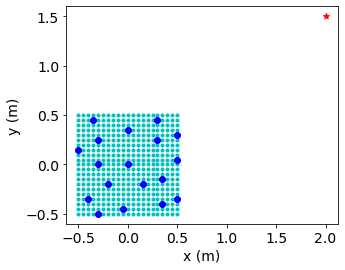

In [4]:
# Number of mics
numMic = 18
idxMic_all = np.load('mic_idx.npy')
idxMic_sel = idxMic_all[0:numMic]

idxEval = np.where(np.isclose(posAll[:,2], 0.0))[0]
numEval = idxEval.shape[0]
posEval = posAll[idxEval,:]

posEvalX = np.unique(posEval[:,0].round(4))
posEvalY = np.unique(posEval[:,1].round(4))
posEvalZ = np.unique(posEval[:,2].round(4))
numEvalXYZ = (posEvalX.shape[0], posEvalY.shape[0], posEvalZ.shape[0])

idxMic = []
for i in range(numMic):
    idx = np.where(np.isclose(idxEval, idxMic_sel[i]))[0]
    idxMic.append(idx[0])

posMic = posEval[idxMic,:]

idxMicXY = []
for i in range(numMic):
    idxX = np.where(np.isclose(posEvalX, posMic[i,0]))[0]
    idxY = np.where(np.isclose(posEvalY, posMic[i,1]))[0]
    idxMicXY.append([idxX[0], idxY[0]])
idxMicXY = np.array(idxMicXY)

# Plot geometry
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()
ax.scatter(posEval[:,0], posEval[:,1], marker='.', color='c')
ax.scatter(posMic[:,0], posMic[:,1], marker='o', color='b')
ax.scatter(posSrc[:,0], posSrc[:,1], marker='*', color='r')
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

samplerate (Hz):  8000
ir length: 5462


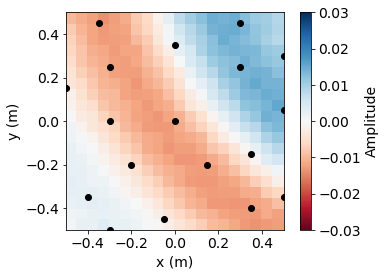

In [5]:
irEval = irAll[0,idxEval,:]

downSampling = 6
irEval = signal.resample_poly(irEval, up=1, down=downSampling, axis=-1)
samplerate = samplerate_raw // downSampling
print('samplerate (Hz): ', samplerate)

# IR length
irLen = irEval.shape[1]
print('ir length:', irLen)

# Evaluation signal
maxFreq = 500
h = signal.firwin(numtaps=64, cutoff=maxFreq, fs=samplerate)
sigEval = signal.filtfilt(h, 1, irEval, axis=-1)

# Observed signal
sigMic = sigEval[idxMic,:]

# Time 
sigLen = sigEval.shape[1]
t = np.arange(sigLen)/samplerate

# Draw pressure distribution
xx, yy = np.meshgrid(posEvalX, posEvalY)

posEvalXY, sigEvalXY, _ = irutil.sortIR3(posEval, sigEval[None,:,:], numEvalXYZ, posEvalX, posEvalY, posEvalZ)
sigEvalXY = np.squeeze(sigEvalXY)

tIdx = 1422

fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolor(xx, yy, sigEvalXY[:,:,tIdx], cmap='RdBu', vmin=-0.03, vmax=0.03)
ax.scatter(posMic[:,0], posMic[:,1], marker='o', color='k')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


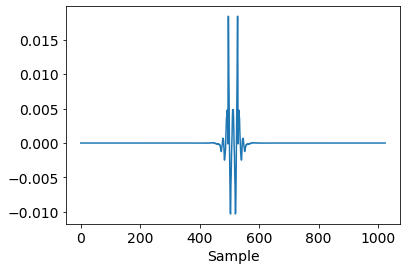

In [6]:
# Sound speed (m/s)
c = 347.0

# Regularization parameter
kerReg = 1e-1

# FFT parameters
fftlen = 16384

# Filter parameters
smplShift = 512
filterLen = 1025
freq = np.arange(1,fftlen/2+1)/fftlen*samplerate

# Kernel interpolation filter
def kiFilterGen():
    k = 2 * np.pi * freq[:,None,None] / c
    distMat = distfuncs.cdist(posMic, posMic)[None, :, :]
    K = special.spherical_jn(0, k * distMat)
    Kinv = np.linalg.inv(K + kerReg * np.eye(numMic))
    distVec = np.transpose(distfuncs.cdist(posEval, posMic), (1, 0))[None,:,:]
    kappa = special.spherical_jn(0, k * distVec)
    kiTF = np.transpose(kappa, (0, 2, 1)) @ Kinv
    kiTF = np.concatenate((np.zeros((1,numEval,numMic)), kiTF, kiTF[int(fftlen/2)-2::-1,:,:].conj()))
    kiFilter =  np.fft.ifft(kiTF, n=fftlen, axis=0).real
    kiFilter = np.concatenate((kiFilter[fftlen-smplShift:fftlen,:,:], kiFilter[:filterLen-smplShift,:,:]))
    return kiFilter

def kiFilterGenDir():
    kerAng = np.arctan2(posSrc[0,1],posSrc[0,0])
    kerBeta = 2.0
    k = 2 * np.pi * freq[:,None,None] / c
    rDiffMat = (np.tile(posMic[:,None,:], (1,numMic,1)) - np.tile(posMic[None,:,:], (numMic,1,1)))[None,:,:,:]
    distMat = 1j*np.sqrt((kerBeta*np.cos(kerAng) + 1j*k*rDiffMat[:,:,:,0])**2 + (kerBeta*np.sin(kerAng) + 1j*k*rDiffMat[:,:,:,1])**2)
    K = special.spherical_jn(0, distMat)
    Kinv = np.linalg.inv(K + kerReg * np.eye(numMic))
    rDiffVec = (np.tile(posEval[None,:,:], (numMic,1,1)) - np.tile(posMic[:,None,:], (1,numEval,1)))[None,:,:,:]
    distVec = 1j*np.sqrt((kerBeta*np.cos(kerAng) + 1j*k*rDiffVec[:,:,:,0])**2 + (kerBeta*np.sin(kerAng) + 1j*k*rDiffVec[:,:,:,1])**2)
    kappa = special.spherical_jn(0, distVec)
    kiTF = np.transpose(kappa, (0, 2, 1)) @ Kinv
    kiTF = np.concatenate((np.zeros((1,numEval,numMic)), kiTF, kiTF[int(fftlen/2)-2::-1,:,:].conj()))
    kiFilter =  np.fft.ifft(kiTF, n=fftlen, axis=0).real
    kiFilter = np.concatenate((kiFilter[fftlen-smplShift:fftlen,:,:], kiFilter[:filterLen-smplShift,:,:]))
    return kiFilter

kiFilter = kiFilterGen()

# Plot filter
fig, ax = plt.subplots()
ax.plot(kiFilter[:,0,0])
plt.xlabel('Sample')
plt.show()


In [7]:
# Convolution inerpolation filter
specMic = np.fft.fft(sigMic.T, n=fftlen, axis=0)[:,:,None]
specKiFilter = np.fft.fft(kiFilter, n=fftlen, axis=0)

specEst = np.squeeze(specKiFilter @ specMic)
sigEst = np.fft.ifft(specEst, n=fftlen, axis=0).real.T
sigEst = sigEst[:,smplShift:sigLen+smplShift]

mse = 10*np.log10(np.sum(np.abs(sigEst - sigEval)**2) / np.sum(np.abs(sigEval)**2))
print('MSE: ', mse)

posEstXY, sigEstXY, _ = irutil.sortIR3(posEval, sigEst[None,:,:], numEvalXYZ, posEvalX, posEvalY, posEvalZ)
sigEstXY = np.squeeze(sigEstXY)

distErr = 10*np.log10(np.sum(np.abs(sigEstXY - sigEvalXY) ** 2, axis=-1) / np.sum(np.abs(sigEvalXY) ** 2, axis=-1))


MSE:  -13.69560305645118


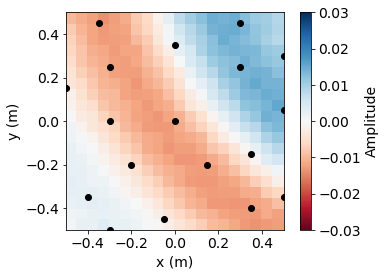

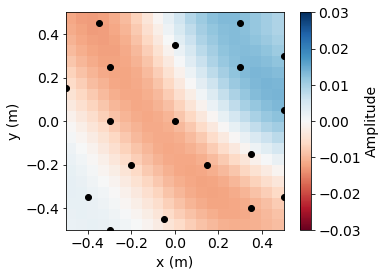

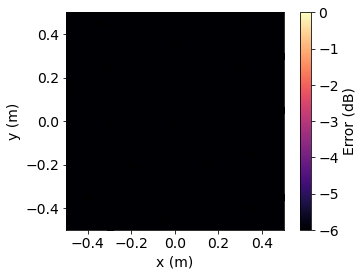

In [8]:
# Draw pressure distribution

tIdx = 1422

fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolor(xx, yy, sigEvalXY[:,:,tIdx], cmap='RdBu', vmin=-0.03, vmax=0.03)
ax.scatter(posMic[:,0], posMic[:,1], marker='o', color='k')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolor(xx, yy, sigEstXY[:,:,tIdx], cmap='RdBu', vmin=-0.03, vmax=0.03)
ax.scatter(posMic[:,0], posMic[:,1], marker='o', color='k')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# Draw error distribution

fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolor(xx, yy, distErr, cmap='magma', vmin=-20.0, vmax=0.0)
ax.scatter(posMic[:,0], posMic[:,1], marker='o', color='k')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Error (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()